In [1]:
import pandas as pd
import re

df = pd.read_csv('sleep-data.csv', sep=';')

def parse_time(time_str):
    match = re.match(r"(\d+):(\d+)", time_str)
    if match:
        hours, minutes = map(int, match.groups())
        return hours + minutes / 60
    else:
        return null

# preprocessing data to have values that are easier to handle

df['Start'] = pd.to_datetime(df['Start'])
df['End'] = pd.to_datetime(df['End'])
df['Sleep quality'] = df['Sleep quality'].astype(str).str.rstrip('%').astype(float) / 100
df['Time in bed'] = df['Time in bed'].apply(parse_time)
df['Heart rate'] = pd.to_numeric(df['Heart rate'], errors='coerce')
df['Activity (steps)'] = pd.to_numeric(df['Activity (steps)'], errors='coerce')

# add weekday column. 0 is monday and 6 is sunday. this is based on end column in case they started to sleep after midnight

df['Weekday'] = df['End'].dt.dayofweek

# make mood column numerable

moods = {':)': 1, ':(': -1, ':|': 0}
df['Wake up'] = df['Wake up'].map(moods)

# remove datapoints that are just naps

df = df[df['Time in bed'] >= 1]

# fill null values with 0

df.fillna(0, inplace=True)

# change column order to more fluent observing, and remove irrelevant columns

df = df[['End', 'Weekday', 'Time in bed', 'Sleep quality', 'Wake up', 'Sleep Notes', 'Activity (steps)', 'Heart rate']]

df.head()

,End,Weekday,Time in bed,Sleep quality,Wake up,Sleep Notes,Activity (steps),Heart rate
0,2014-12-30 07:30:13,1,8.533333,1.00,1.0,0,0,59.0
2,2014-12-31 07:13:31,2,8.500000,0.98,0.0,0,0,57.0
3,2015-01-01 06:03:01,3,7.533333,0.65,0.0,0,0,0.0
4,2015-01-02 04:56:35,4,6.733333,0.72,1.0,Drank coffee:Drank tea,0,68.0
5,2015-01-03 07:47:23,5,7.200000,0.83,1.0,Drank coffee:Drank tea,0,60.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

In [3]:
def descriptive_analysis(df):
    desc_stats = {
        'overall_summary': df.describe(),
        'sleep_quality_by_weekday': df.groupby('Weekday')['Sleep quality'].agg(['mean', 'std']),
        'time_in_bed_by_weekday': df.groupby('Weekday')['Time in bed'].agg(['mean', 'std'])
    }
    
    # key relationships
    plt.figure(figsize=(15, 10))
    
    # sleep quality distributon
    plt.subplot(2, 2, 1)
    sns.histplot(df['Sleep quality'], kde=True)
    plt.title('Sleep Quality Distribution')
    
    # time in bed vs sleep quality
    plt.subplot(2, 2, 2)
    sns.scatterplot(x='Time in bed', y='Sleep quality', data=df)
    plt.title('Time in Bed vs Sleep Quality')
    
    # sleep quality by weekday
    plt.subplot(2, 2, 3)
    sns.boxplot(x='Weekday', y='Sleep quality', data=df)
    plt.title('Sleep Quality Across Weekdays')
    
    # activity vs sleep quality
    df_filtered = df[df['Activity (steps)'] != 0]
    plt.subplot(2, 2, 4)
    sns.scatterplot(x='Activity (steps)', y='Sleep quality', data=df_filtered)
    plt.title('Activity vs Sleep Quality')
    
    plt.tight_layout()
    
    return desc_stats

/opt/software/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


{'overall_summary':                               End     Weekday  Time in bed  Sleep quality  \
 count                         875  875.000000   875.000000     875.000000   
 mean   2016-08-25 22:43:02.072000    2.693714     7.731219       0.758251   
 min           2014-12-30 07:30:13    0.000000     1.000000       0.120000   
 25%    2015-11-30 18:19:58.500000    1.000000     7.333333       0.690000   
 50%           2016-09-21 06:15:30    3.000000     7.733333       0.770000   
 75%           2017-05-25 18:31:05    4.000000     8.216667       0.840000   
 max           2018-02-17 07:48:04    6.000000    10.766667       1.000000   
 std                           NaN    1.860069     1.027804       0.133144   
 
           Wake up  Activity (steps)  Heart rate  
 count  875.000000        875.000000  875.000000  
 mean     0.244571       2790.780571   11.138286  
 min     -1.000000          0.000000    0.000000  
 25%      0.000000          0.000000    0.000000  
 50%      0.000000    

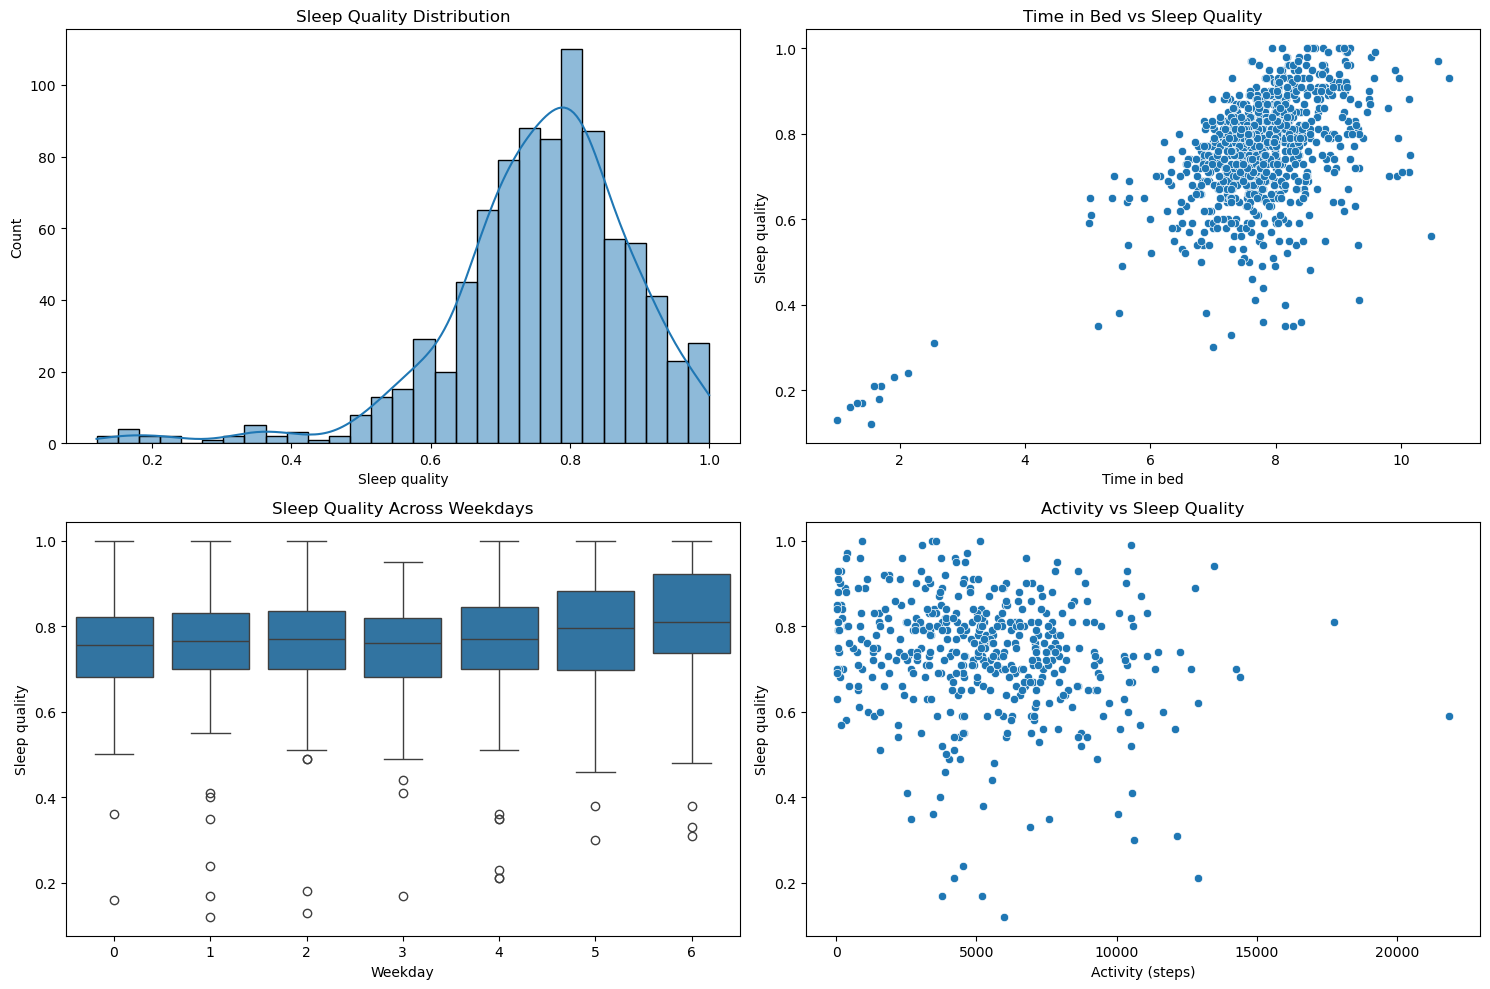

In [4]:
descriptive_analysis(df)

In [5]:
def statistical_analysis(df):
    # correlation matrix and heatmap
    correlation_matrix = df[['Time in bed', 'Sleep quality', 'Activity (steps)', 'Heart rate']].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')

    # activity vs sleep quality
    X = df['Activity (steps)'].values.reshape(-1, 1)
    y = df['Sleep quality'].values
    reg_model = LinearRegression().fit(X, y)
    r_squared = reg_model.score(X, y)

    # scatter plot with regression line
    df_filtered = df[df['Activity (steps)'] != 0]
    plt.figure(figsize=(8, 6))
    sns.regplot(x='Activity (steps)', y='Sleep quality', data=df_filtered)

    return {
        'correlation_matrix': correlation_matrix,
        'activity_sleep_regression': {
            'slope': reg_model.coef_[0],
            'intercept': reg_model.intercept_,
            'r_squared': r_squared
        }
    }


{'correlation_matrix':                   Time in bed  Sleep quality  Activity (steps)  Heart rate
 Time in bed          1.000000       0.580746         -0.040692   -0.027881
 Sleep quality        0.580746       1.000000         -0.246023    0.103423
 Activity (steps)    -0.040692      -0.246023          1.000000   -0.376546
 Heart rate          -0.027881       0.103423         -0.376546    1.000000,
 'activity_sleep_regression': {'slope': -9.378924820018339e-06,
  'intercept': 0.784425949740025,
  'r_squared': 0.060527471736812055}}

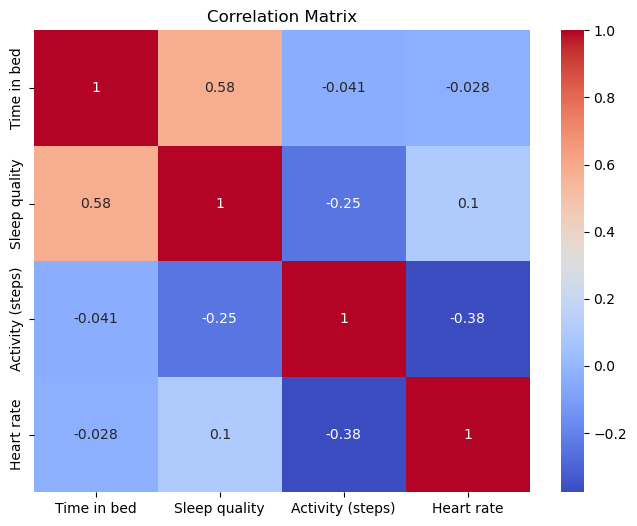

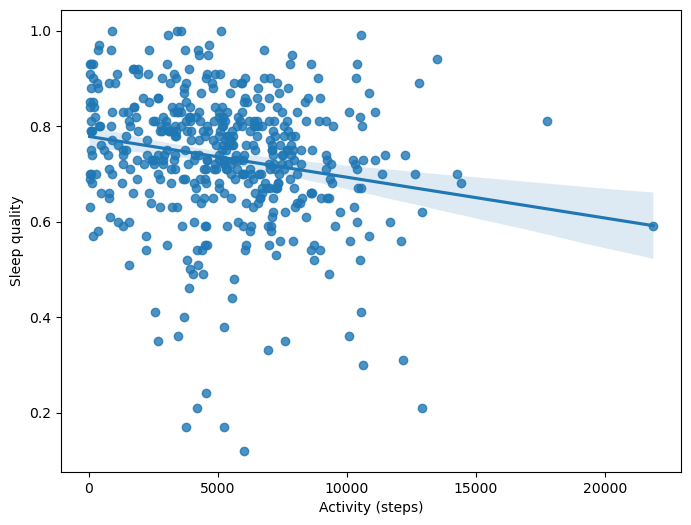

In [6]:
statistical_analysis(df)

In [7]:
def handle_missing_values(df):
    processed_df = df.copy()
    processed_df['Date'] = pd.to_datetime(processed_df['End'])
    processed_df.set_index('Date', inplace=True)
    processed_df['Sleep quality'] = processed_df['Sleep quality'].interpolate(method='linear')
    processed_df['Time in bed'] = processed_df['Time in bed'].interpolate(method='linear')
    processed_df['Heart rate'].fillna(processed_df['Heart rate'].median(), inplace=True)
    processed_df['Activity (steps)'].fillna(0, inplace=True)
    
    daily_sleep_quality = processed_df['Sleep quality'].resample('D').mean()
    daily_time_in_bed = processed_df['Time in bed'].resample('D').mean()
    
    daily_sleep_quality = daily_sleep_quality.interpolate(method='time')
    daily_time_in_bed = daily_time_in_bed.interpolate(method='time')
    
    return {
        'daily_sleep_quality': daily_sleep_quality,
        'daily_time_in_bed': daily_time_in_bed,
    }

In [8]:
def time_series_analysis(df):
    processed_data = handle_missing_values(df)
    
    daily_sleep_quality = processed_data['daily_sleep_quality']
    daily_time_in_bed = processed_data['daily_time_in_bed']
    
    period = max(7, len(daily_sleep_quality) // 4)

    sleep_quality_decomp = seasonal_decompose(
        daily_sleep_quality, 
        period=period, 
        extrapolate_trend='freq'
    )

    time_in_bed_decomp = seasonal_decompose(
        daily_time_in_bed, 
        period=period, 
        extrapolate_trend='freq'
    )
        
    
    plt.figure(figsize=(15, 12))
    
    plt.subplot(2, 2, 1)
    plt.plot(sleep_quality_decomp.trend)
    plt.title('Sleep Quality Trend')
    
    plt.subplot(2, 2, 2)
    plt.plot(sleep_quality_decomp.seasonal)
    plt.title('Sleep Quality Seasonality')
    
    plt.subplot(2, 2, 3)
    plt.plot(time_in_bed_decomp.trend)
    plt.title('Time in Bed Trend')
    
    plt.subplot(2, 2, 4)
    plt.plot(time_in_bed_decomp.seasonal)
    plt.title('Time in Bed Seasonality')
    
    plt.tight_layout()
    
    return {
        'sleep_quality_trend': sleep_quality_decomp.trend,
        'sleep_quality_seasonal': sleep_quality_decomp.seasonal,
        'time_in_bed_trend': time_in_bed_decomp.trend,
        'time_in_bed_seasonal': time_in_bed_decomp.seasonal
    }

/tmp/ipykernel_427/3363607298.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  processed_df['Heart rate'].fillna(processed_df['Heart rate'].median(), inplace=True)
/tmp/ipykernel_427/3363607298.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].

{'sleep_quality_trend': Date
 2014-12-30    0.794303
 2014-12-31    0.794277
 2015-01-01    0.794252
 2015-01-02    0.794226
 2015-01-03    0.794201
                 ...   
 2018-02-13    0.763287
 2018-02-14    0.763350
 2018-02-15    0.763412
 2018-02-16    0.763474
 2018-02-17    0.763536
 Freq: D, Name: trend, Length: 1146, dtype: float64,
 'sleep_quality_seasonal': Date
 2014-12-30    0.083151
 2014-12-31    0.087174
 2015-01-01   -0.095096
 2015-01-02   -0.040168
 2015-01-03   -0.050175
                 ...   
 2018-02-13    0.098372
 2018-02-14    0.050605
 2018-02-15    0.100175
 2018-02-16    0.083151
 2018-02-17    0.087174
 Freq: D, Name: seasonal, Length: 1146, dtype: float64,
 'time_in_bed_trend': Date
 2014-12-30    7.653625
 2014-12-31    7.653987
 2015-01-01    7.654348
 2015-01-02    7.654709
 2015-01-03    7.655070
                 ...   
 2018-02-13    7.970452
 2018-02-14    7.971137
 2018-02-15    7.971822
 2018-02-16    7.972507
 2018-02-17    7.973192
 Freq: D, N

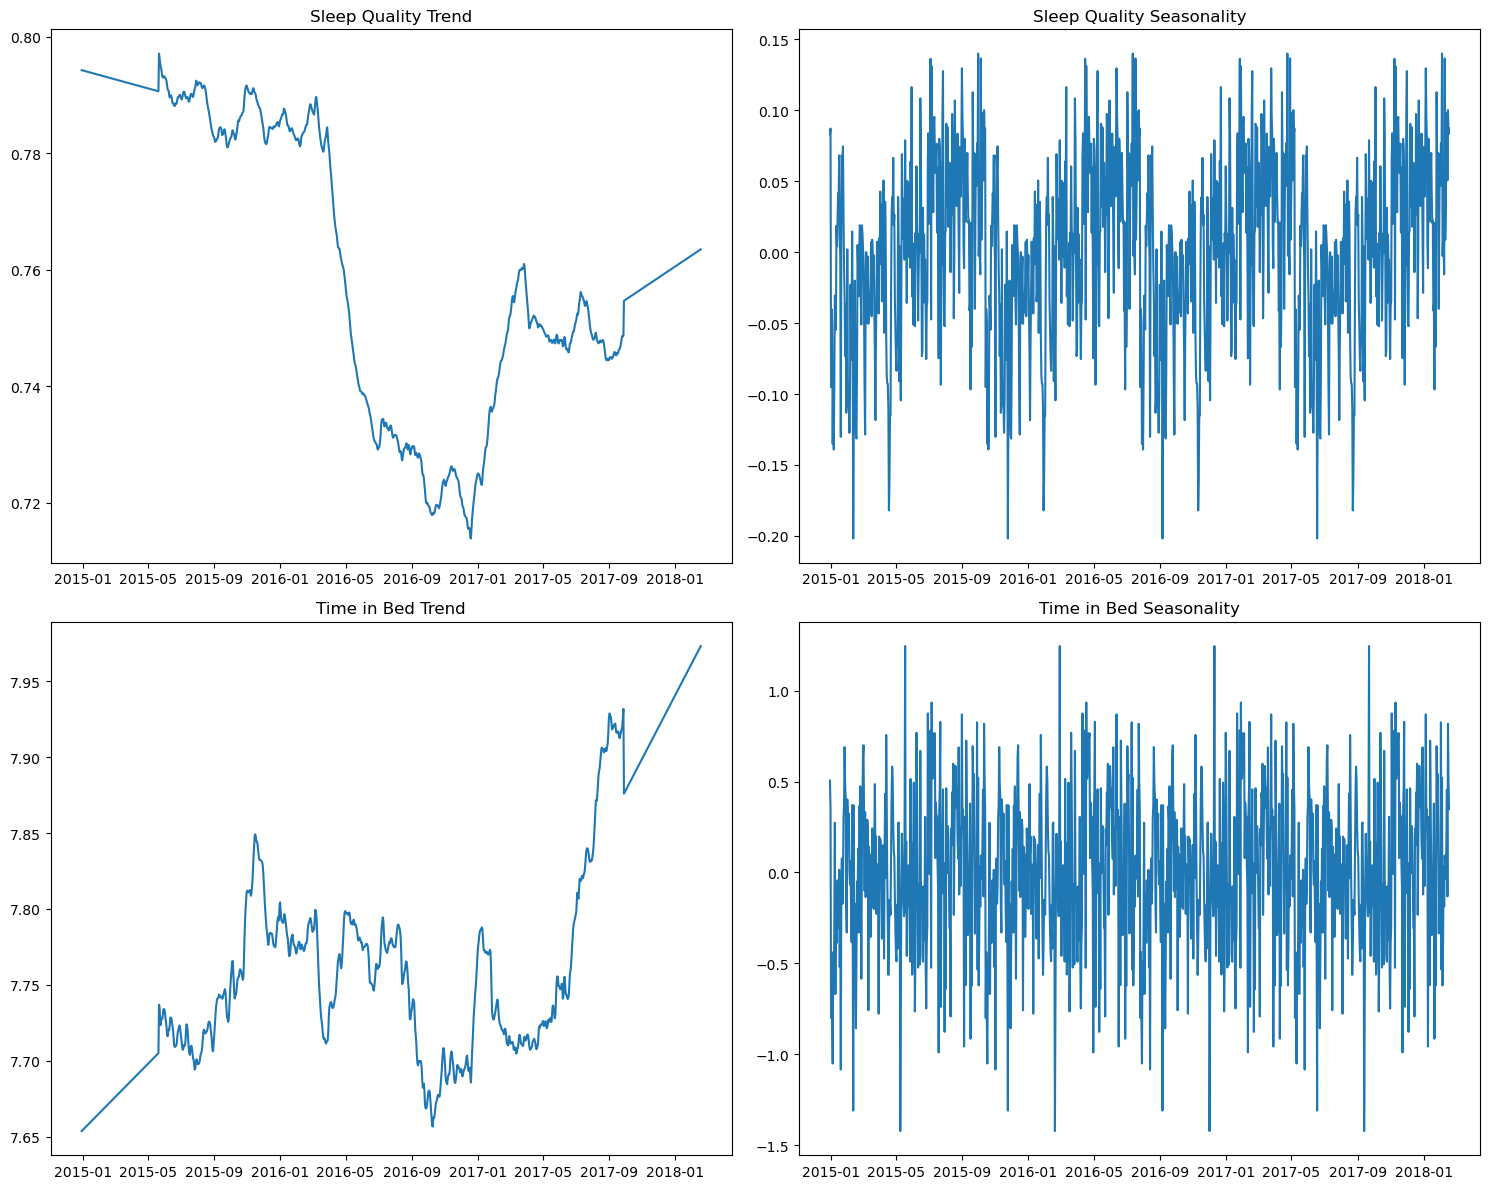

In [9]:
time_series_analysis(df)